0. Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,BatchNormalization, MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

1. Load data 

In [3]:
breed_data = pd.read_csv('./dog_data/labels.csv')
train = "./dog_data/train/"
test="./dog_data/test/"

In [4]:
breed_data.tail()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


In [5]:
#Number of different breed type
breed_data.breed.value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

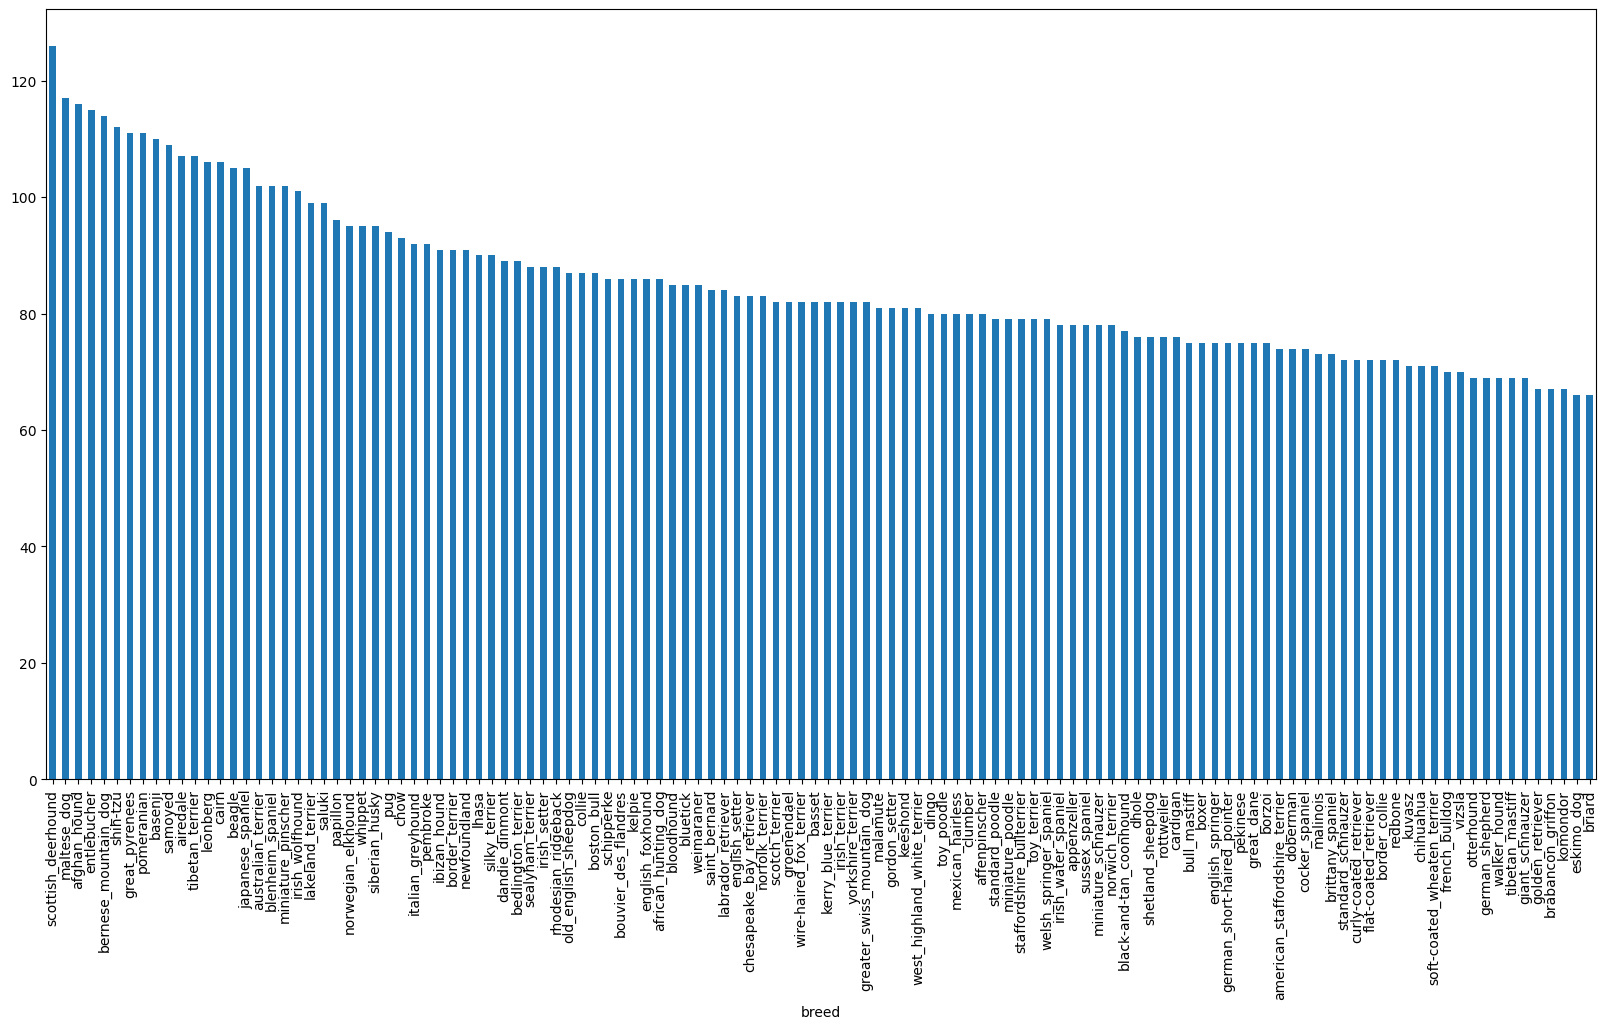

In [6]:
breed_data["breed"].value_counts().plot.bar(figsize=(20, 10));

2. Select representative varieties

In [7]:
#Top 20 breed
top_20=list(breed_data.breed.value_counts()[0:20].index)
top_20

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'leonberg',
 'cairn',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'blenheim_spaniel',
 'miniature_pinscher',
 'irish_wolfhound']

In [8]:
top20_breed=breed_data[breed_data.breed.isin(top_20)]
top20_breed.shape # (column num, raw num)

(2184, 2)

In [9]:
#Number of different breed type
top20_breed.breed.value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
tibetan_terrier         107
airedale                107
leonberg                106
cairn                   106
beagle                  105
japanese_spaniel        105
miniature_pinscher      102
australian_terrier      102
blenheim_spaniel        102
irish_wolfhound         101
Name: count, dtype: int64

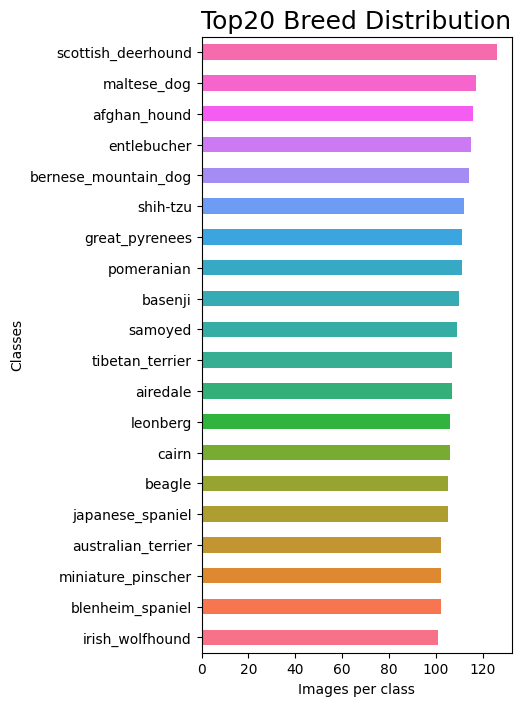

In [10]:
# Create class-specific color mappings
class_colors = sns.color_palette("husl", n_colors=len(top20_breed['breed'].unique()))

# Take a look at the class/breed distribution
ax = pd.value_counts(top20_breed['breed'], ascending=True).plot(kind='barh', fontsize="10", title="Top20 Breed Distribution", figsize=(4, 8), color=class_colors)
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.title.set_size(18)
plt.show()

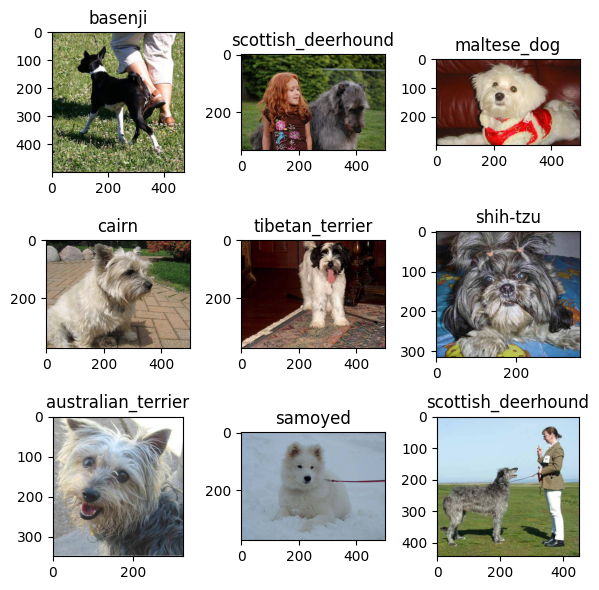

In [11]:
nrow=3
ncol=3
fig,ax=plt.subplots(nrow,ncol,figsize=(6,6))
for i,(img_id,breed) in enumerate(top20_breed[["id","breed"]].values[: nrow*ncol]):
    image_path=os.path.join(train,img_id+".jpg")
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    row=i//ncol
    col=i%ncol
    ax[row,col].imshow(image)
    ax[row,col].set_title(breed)
    # ax[row,col].axis("off")
    
plt.tight_layout()
plt.show()

3. Data preprocessing

In [12]:

num_breed = 20
image_size = 224
batch_size = 32
label_encoder = LabelEncoder()

In [13]:
breed=list(top20_breed["breed"].value_counts().keys())
new=sorted(breed,reverse=True)[: num_breed]
top20_breed=top20_breed.query("breed in @new")
top20_breed

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
29,00bee065dcec471f26394855c5c2f3de,cairn
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier
...,...,...
10212,ffc532991d3cd7880d27a449ed1c4770,tibetan_terrier
10215,ffcde16e7da0872c357fbc7e2168c05f,airedale
10216,ffcffab7e4beef9a9b8076ef2ca51909,samoyed
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale


In [14]:
# Create image_file row 
top20_breed['image_file'] = top20_breed['id'].apply(lambda x: x + ".jpg")
top20_breed.head()

,id,breed,image_file
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,00693b8bc2470375cc744a6391d397ec.jpg
29,00bee065dcec471f26394855c5c2f3de,cairn,00bee065dcec471f26394855c5c2f3de.jpg
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,013f8fdf6d638c7bb042f5f17e8a9fdc.jpg


In [15]:
from tensorflow.keras.applications.mobilenet import preprocess_input

train_data=np.zeros((len(top20_breed),image_size,image_size,3),dtype="float32")
for i,img_id in enumerate(top20_breed["image_file"]):
    img=cv2.resize(cv2.imread(train+img_id,cv2.IMREAD_COLOR),((image_size,image_size)))
    img_array=preprocess_input(np.expand_dims(np.array(img[...,: : -1].astype(np.float32)).copy(),axis=0))
    train_data[i]=img_array

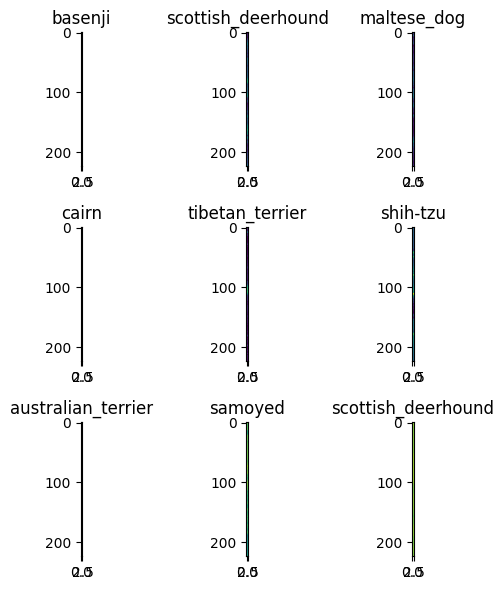

In [16]:
nrow = 3
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(6, 6))

for i, (img_id, breed) in enumerate(top20_breed[["id", "breed"]].values[:nrow * ncol]):
    image_path = os.path.join(train, img_id + ".jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    row = i // ncol
    col = i % ncol

    # 전처리된 이미지 가져오기
    preprocessed_image = train_data[i]

    # 전처리된 이미지 시각화
    ax[row, col].imshow(preprocessed_image[0])  # [0]은 배치 차원을 제거합니다.
    ax[row, col].set_title(breed)
    # ax[row, col].axis("off")  # 이미지에 대한 축을 표시하지 않도록 변경

plt.tight_layout()
plt.show()


In [17]:
train_data[i]

array([[[ 0.4431373 ,  0.70980394,  0.92156863],
        [ 0.4431373 ,  0.70980394,  0.92156863],
        [ 0.4431373 ,  0.70980394,  0.92156863],
        ...,
        [ 0.4666667 ,  0.7019608 ,  0.90588236],
        [ 0.45882356,  0.7019608 ,  0.90588236],
        [ 0.45098042,  0.70980394,  0.90588236]],

       [[ 0.4431373 ,  0.70980394,  0.92156863],
        [ 0.4431373 ,  0.70980394,  0.92156863],
        [ 0.4431373 ,  0.70980394,  0.92156863],
        ...,
        [ 0.4666667 ,  0.7019608 ,  0.90588236],
        [ 0.45882356,  0.7019608 ,  0.90588236],
        [ 0.45098042,  0.70980394,  0.90588236]],

       [[ 0.4431373 ,  0.70980394,  0.92156863],
        [ 0.4431373 ,  0.70980394,  0.92156863],
        [ 0.4431373 ,  0.70980394,  0.92156863],
        ...,
        [ 0.4666667 ,  0.7019608 ,  0.90588236],
        [ 0.45882356,  0.7019608 ,  0.90588236],
        [ 0.45098042,  0.70980394,  0.90588236]],

       ...,

       [[-0.26274508, -0.0745098 , -0.6784314 ],
        [-0

In [18]:
label_data = label_encoder.fit_transform(top20_breed["breed"].values)
# to_categorical 함수는 이전 단계에서 얻은 숫자 레이블을 원-핫 인코딩된 벡터로 변환
label_data = to_categorical(label_data)

4. Data split

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data,label_data,test_size=0.2,random_state=42)

In [20]:
print("========================================")
print("Train Data Shape :",x_train.shape)
print("----------------------------------------")
print("Test Data Shape :",x_test.shape)
print("----------------------------------------")
print("Train Label Data Shape :",y_train.shape)
print("-----------------------------------------")
print("Test Label Data Shape :",y_test.shape)
print("=========================================")

Train Data Shape : (1747, 224, 224, 3)
----------------------------------------
Test Data Shape : (437, 224, 224, 3)
----------------------------------------
Train Label Data Shape : (1747, 20)
-----------------------------------------
Test Label Data Shape : (437, 20)


5. Data Augmentation(데이터 증강)

In [21]:
# TensorFlow의 Keras API를 사용하여 이미지 데이터에 데이터 증강
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

# rotation_range: 무작위 회전 각도 범위 (0~45도).
# width_shift_range 및 height_shift_range: 무작위 수평 및 수직 이동 범위 (전체 너비 또는 높이에 대한 비율).
# shear_range: 무작위 전단 강도.
# zoom_range: 무작위 확대/축소 범위.
# horizontal_flip: 수평 뒤집기 여부.
# fill_mode: 회전 또는 이동 후 채울 픽셀의 전략 (가장 가까운 이웃, 상수 값, 또는 반사).

training_set=train_datagen.flow(x_train,y=y_train,batch_size=128)
testing_set=test_datagen.flow(x_test,y=y_test,batch_size=128)

In [22]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [23]:
resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), train_data)



69/69 [==============================] - 91s 1s/step
Feature maps shape: (2184, 2048)


In [24]:
model = Sequential()
model.add(Dropout(0.7, input_shape=(resnet_features.shape[1],)))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

6. Model training

In [33]:
history = model.fit(resnet_features, label_data,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/20
14/14 [==============================] - 0s 7ms/step - loss: 2.6075 - accuracy: 0.2169 - val_loss: 2.7026 - val_accuracy: 0.1808
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 2.6013 - accuracy: 0.2118 - val_loss: 2.6990 - val_accuracy: 0.1876
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 2.6009 - accuracy: 0.2095 - val_loss: 2.6993 - val_accuracy: 0.1739
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 2.5873 - accuracy: 0.2101 - val_loss: 2.7065 - val_accuracy: 0.1716
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 2.5768 - accuracy: 0.2152 - val_loss: 2.6965 - val_accuracy: 0.1785
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 2.5836 - accuracy: 0.2147 - val_loss: 2.6971 - val_accuracy: 0.1922
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 2.5967 - accuracy: 0.1963 - val_loss: 2.6981 - val_accuracy: 0.1762
Epoch 8/20
14/14 [==

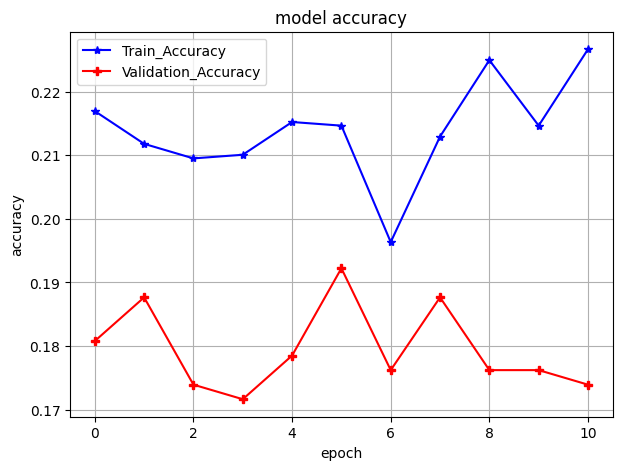

In [34]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],label="Train_Accuracy",color="blue",marker="*")
plt.plot(history.history['val_accuracy'],label="Validation_Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

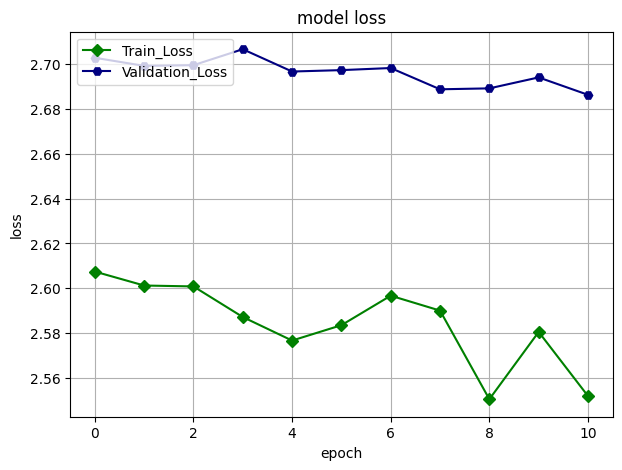

In [35]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],color="green",marker="D")
plt.plot(history.history['val_loss'],color="navy",marker="H")
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Loss', 'Validation_Loss'], loc='upper left')
plt.show()

In [36]:
lab = top20_breed["breed"].unique().tolist()
print(lab)

['basenji', 'scottish_deerhound', 'maltese_dog', 'cairn', 'tibetan_terrier', 'shih-tzu', 'australian_terrier', 'samoyed', 'entlebucher', 'airedale', 'leonberg', 'bernese_mountain_dog', 'afghan_hound', 'miniature_pinscher', 'irish_wolfhound', 'great_pyrenees', 'beagle', 'japanese_spaniel', 'pomeranian', 'blenheim_spaniel']


In [37]:
best_epoch = np.argmin(history.history['val_loss'])  # 또는 'val_accuracy' 등 성능 지표에 따라 선택
best_model = model 

In [38]:
all_predictions = best_model.predict(resnet_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(label_data, axis=1)

69/69 [==============================] - 0s 724us/step


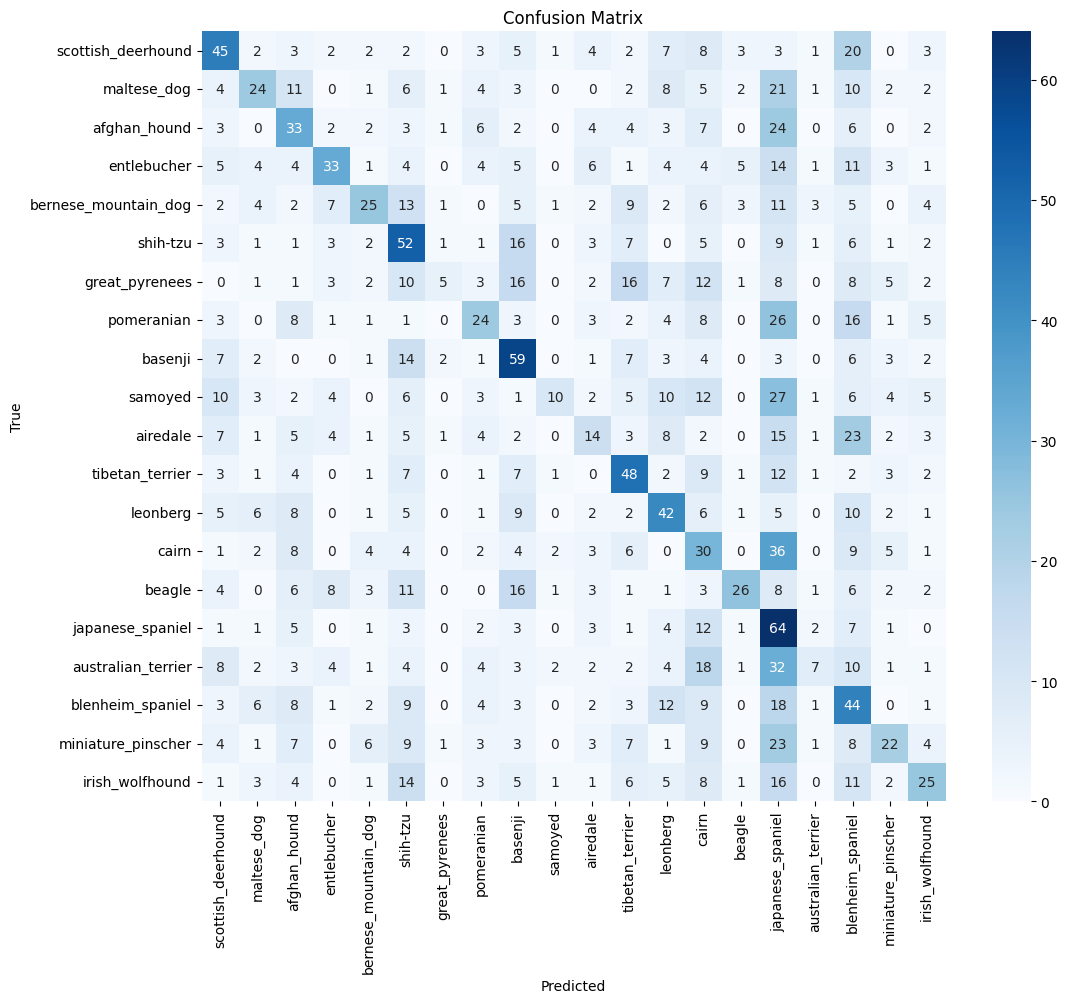

In [39]:
conf_matrix = confusion_matrix(true_labels, all_predicted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=top_20, yticklabels=top_20)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [40]:
print(classification_report(y_test,all_predicted_labels,target_names=lab))

ValueError: Found input variables with inconsistent numbers of samples: [437, 2184]